<a href="https://colab.research.google.com/github/grellert/curso-computer-vision/blob/main/Curso_VW_Semana_1_Tarefa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!gdown https://drive.google.com/uc?id=1hyC8RLxt-mQloeE0un-dbI3MnlAA0ATJ
!unzip -q chinese_traffic_signs.zip

Downloading...
From (original): https://drive.google.com/uc?id=1hyC8RLxt-mQloeE0un-dbI3MnlAA0ATJ
From (redirected): https://drive.google.com/uc?id=1hyC8RLxt-mQloeE0un-dbI3MnlAA0ATJ&confirm=t&uuid=b88cc99f-d96a-488e-8ff1-7aa29836c044
To: /content/chinese_traffic_signs.zip
100% 194M/194M [00:01<00:00, 187MB/s]


# Especificação

Para esta tarefa, cada grupo deverá implementar um sistema de detecção de placas utilizando algoritmos clássicos de Visão Computacional combinados com métodos clássicos de Aprendizado de Máquina.

O trabalho está dividido em no mínimo 4 etapas:
 1. Detecção de bordas de placas e identificação de bounding boxes.
 2. Segmentação das bounding boxes para remover informação de fundo das placas.
 3. Extração de descritores.
 4. Classificação das boundings boxes segmentadas utilizando algum algoritmo de Aprendizado de Máquina (exemplo: SVM).

Mais etapas podem ser adicionadas pelo grupo para aumentar o desempenho da etapa de predição.

O data set "Chinese Traffic Signs" será usado para os experimentos. Este data set contém diversas imagens de placas, além das anotações para cada uma. As anotações incluem coordenadas da bounding box (x1, y1, x2, y2), largura, altura e classe (categoria) da placa.

O grupo deverá separar 20% do data set para teste, preservando a mesma distribuição das categorias de placas.

Parâmetros dos detectores de borda, assim como dos segmentadores devem ser ajustados para garantir um bom desempenho.

Os resultados devem ser avaliados considerando as seguintes métricas: IoU para detecção de bordas e acurácia para classificação.

Como entrega, o grupo deverá apresentar uma cópia deste Colab Notebook com comentários sobre como cada etapa foi desenvolvida, assim como os resultados. Recomenda-se testar e comparar mais uma configuração.

Exemplo:
- Experimento 1: Detecção de bordas usando Canny com $\sigma=3$, segmentação usando Canny + Open/Close + Componentes conectadas com $\sigma=4$, classificação com SVM ($C=1.0$, kernel $RBF$).
- Experimento 2: Detecção de bordas usando Canny com $\sigma=5$, segmentação usando Canny + Open/Close + Componentes conectadas com $\sigma=5$, classificação com SVM ($C=1.0$, kernel $RBF$).

# Introdução

Vamos primeiro entender um pouco nossos dados.

O código abaixo apresenta inicialmente três funções auxiliares que iremos utilizar posteriormente:
- **plot_bbox**: recebe uma bounding box e plota na tela.
- **compute_iou**: recebe duas bounding boxes e retornar o score Intersection over Union.
- **create_image_dataset**: faz alguns ajustes nas imagens e retorna um data set no formato X (imagens tratadas) e y (categorias - tipos de placas).

Cada grupo tem liberdade para modificar estes métodos de acordo com a sua necessidade.

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# plot one or more bboxes on the image
def plot_bbox(image, bbox, color = 'red', title = None):
    plt.imshow(image)
    min_x, min_y, max_x, max_y = bbox

    if title is not None:
        plt.title(title)
    plt.plot([min_x, min_x, max_x, max_x, min_x], [min_y, max_y, max_y, min_y, min_y], color = color)


def compute_iou(bbox1, bbox2):
    # prompt: compute the IOU between the two bounding boxes
    min_x1, min_y1, max_x1, max_y1 = bbox1
    min_x2, min_y2, max_x2, max_y2 = bbox2

    intersection_area = (min(max_x1, max_x2) - max(min_x1, min_x2)) * (min(max_y1, max_y2) - max(min_y1, min_y2))

    # Compute the area of the union rectangle
    union_area = (max_x1 - min_x1) * (max_y1 - min_y1) + (max_x2 - min_x2) * (max_y2 - min_y2) - intersection_area

    # Compute the IOU
    iou = intersection_area / union_area

    return iou

def create_image_dataset(img_list, target_list):
    imgs_rescale = []

    for file_name in img_list:
        img = skimage.io.imread(os.path.join(IMG_PATH, file_name))
        img_res = skimage.transform.resize(img, (128,128))

        imgs_rescale.append(img_res)
    imgs_rescale = np.array(imgs_rescale)
    X = imgs_rescale
    y = np.array(target_list)

    return X,y

- Vamos visualizar uma das imagens pra entender melhor como as placas estão representadas, aplicando o filtro Canny para uma tentativa de encontrar a caixa delimitadora.

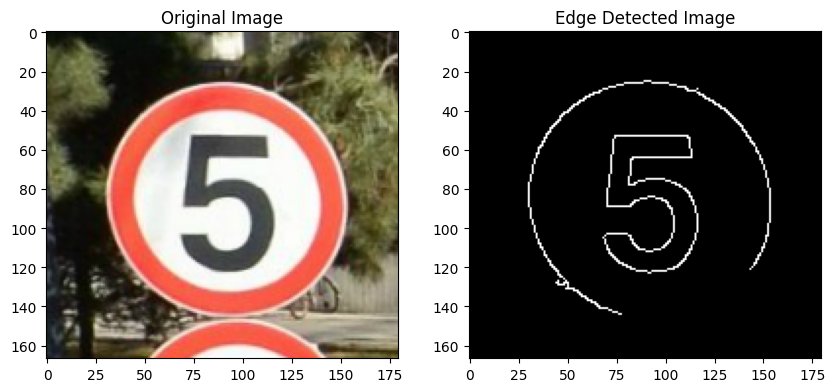

In [5]:
# prompt: open image called 01.png, compute its edges using canny edge detectors
# data source: https://www.kaggle.com/datasets/dmitryyemelyanov/chinese-traffic-signs?resource=download
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('images/000_1_0005_1_j.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, 400, 1000)

# Plot the original image and the edge detected image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detected Image')
plt.show()


- Este resultado já foi bom o bastante para este exemplo, portanto vamos computar a bounding box do Canny usando os valores mínimos e máximos das linhas e colunas com borda.

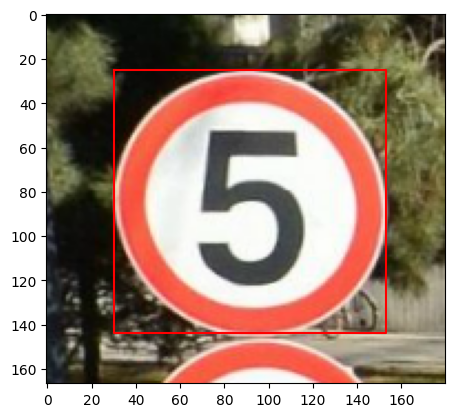

In [48]:

import matplotlib.pyplot as plt
import numpy as np
# Find the minimum and maximum x and y coordinates of the edge pixels
y, x = np.where(edges == 255)
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

bbox_pred = [min_x, min_y, max_x, max_y]
plot_bbox(image_rgb, bbox_pred)


- Vamos agora recuperar os dados anotados da placa (documento `annotations.csv`) e comparar a bounding box real com aquela que estimamos com nosso detector de bordas.

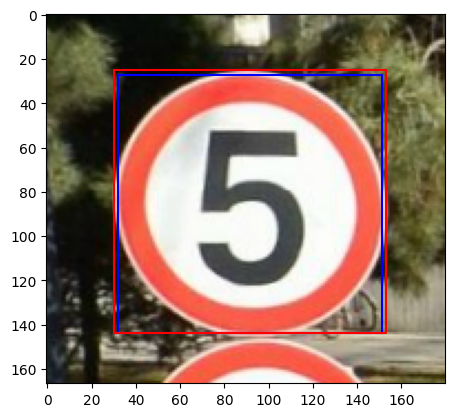

In [49]:
w,h,x1,y1,x2,y2 = 180,167,32,27,151,144
bbox_true = [x1, y1, x2, y2]
bbox_pred = [min_x, min_y, max_x, max_y]

plot_bbox(image_rgb, bbox_true, color = 'blue')
plot_bbox(image_rgb, bbox_pred)

- Visualmente parecem próximas, mas precisamos de uma métrica objetiva para poder comparar isso melhor com outras abordagens. Vamos computar o IoU para isso.

In [56]:

iou = compute_iou(bbox_true, bbox_pred)

print(f"The IOU between the two bounding boxes is {iou:.3f}")


The IOU between the two bounding boxes is 0.951


# Preparação do Data Set

- Agora vamos montar nosso Data Set com todas as imagens que temos na pasta. Para isso, vamos unir as imagens com os dados anotados em uma estrutura só chamada `dataset`, a qual será um `DataFrame` da biblioteca `Pandas` (breve tutorial [aqui](https://pandas.pydata.org/docs/user_guide/10min.html)).

In [58]:
import pandas as pd
import os

IMG_PATH = './images'

# Get a list of all image files in the "images" folder
image_files = [f for f in os.listdir(IMG_PATH) if f.endswith('.png')]

# Load the annotations file
annotations_df = pd.read_csv('annotations.csv')

# Merge the image paths and the annotations
dataset = pd.DataFrame({
    'file_name': image_files,
})

# Merge the image paths and the annotations based on the image name
dataset = dataset.merge(annotations_df, on='file_name')

# Print the dataset
print(dataset)


           file_name  width  height  x1  y1   x2   y2  category
0     026_0028_j.png     63      62   7   5   57   53        26
1     049_0018_j.png    180     172  33  30  146  133        49
2       002_0006.png    170     161  31  30  139  139         2
3       043_0013.png    119     120  16  11  107   93        43
4       026_0032.png    110     101  16   9   90   85        26
...              ...    ...     ...  ..  ..  ...  ...       ...
6159  041_1_0005.png    102      98  15  14   82   85        41
6160    016_0031.png    142     154  17  20  129  134        16
6161    054_0153.png    231     208  49  31  187  166        54
6162  024_1_0034.png    162     145  27  14  147  134        24
6163  028_1_0116.png    239     227  41  34  199  189        28

[6164 rows x 8 columns]


- É importante entender os limites de escala das nossas imagens. Vamos analisar o menor e maior valor de largura a altura que temos no nosso conjunto.

Minimum width: 26
Maximum width: 491
Minimum height: 28
Maximum height: 402


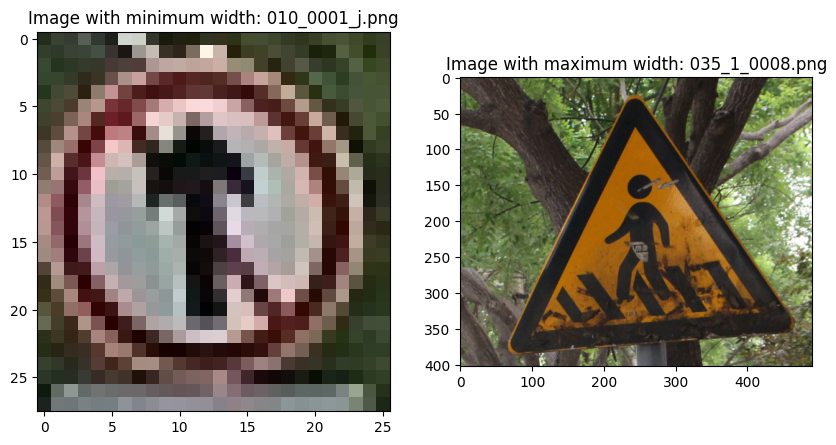

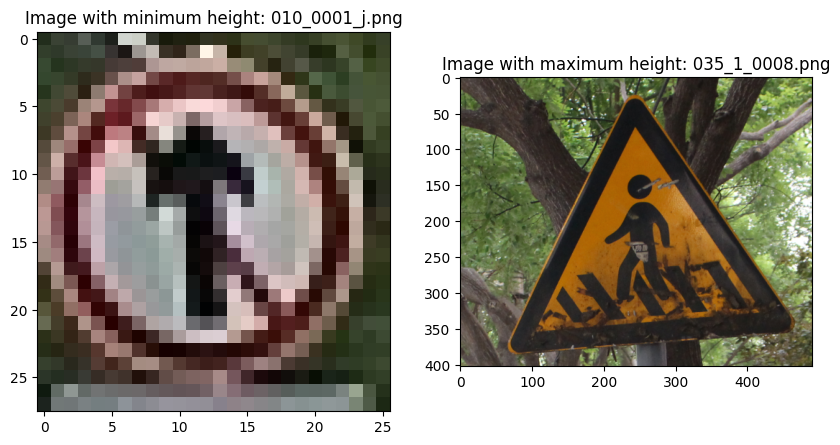

In [62]:
# prompt: compute min/max width and height of the images located in image_files. Also plot the image names with min/max width and heihgt

import matplotlib.pyplot as plt
# Compute the minimum and maximum width and height of the images
min_width = dataset['width'].min()
max_width = dataset['width'].max()
min_height = dataset['height'].min()
max_height = dataset['height'].max()

# Print the minimum and maximum width and height
print(f"Minimum width: {min_width}")
print(f"Maximum width: {max_width}")
print(f"Minimum height: {min_height}")
print(f"Maximum height: {max_height}")

# Plot the image names with min/max width and height
min_width_image = dataset.loc[dataset['width'] == min_width, 'file_name'].values[0]
max_width_image = dataset.loc[dataset['width'] == max_width, 'file_name'].values[0]
min_height_image = dataset.loc[dataset['height'] == min_height, 'file_name'].values[0]
max_height_image = dataset.loc[dataset['height'] == max_height, 'file_name'].values[0]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH, min_width_image)), cv2.COLOR_BGR2RGB))
plt.title(f'Image with minimum width: {min_width_image}')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH, max_width_image)), cv2.COLOR_BGR2RGB))
plt.title(f'Image with maximum width: {max_width_image}')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH, min_height_image)), cv2.COLOR_BGR2RGB))
plt.title(f'Image with minimum height: {min_height_image}')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(IMG_PATH, max_height_image)), cv2.COLOR_BGR2RGB))
plt.title(f'Image with maximum height: {max_height_image}')
plt.show()


- Como podemos ver, temos imagens de tamanhos diversos, portanto o nosso método `create_image_dataset` será útil. Este método já inclui dentro dele uma etapa de scaling que converte todas as imagens para a resoulução 128x128.

In [76]:
# prompt: create a data set with X = images y = [x1,  y1,   x2,   y2]

import numpy as np
import skimage


X,y = create_image_dataset(dataset['file_name'].values, dataset['category'].values)

# Agora é com Vocês!

- Já temos o data set pronto, portanto cabe ao grupo realizar as operações de detecção de bordas, segmentação e classificação para a tarefa de detecção de placas.

- Análises interessantes:
 - Qual o desempenho de um modelo sem nenhum tratamento de imagem?
 - Qual o desempenho se usarmos somente a área da bounding box?
 - Qual o desempenho se usarmos também segmentação para remover informação de background?
 - Qual o desempenho também usarmos métodos de extração de descritores como HoG?